In [1]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#size is the number of trial functions in each region
size = 3
steps = 300

c_x, c_y, c_z, y, Kn, h = symbols('c_x c_y c_z y Kn h')

vs = symbols('v1:%d'%(size+1)) 
bs = symbols('b1:%d'%(size+1))

#maybe change the name of this shite
v_derivs = symbols('vd1:%d'%(size+1)) 
b_derivs = symbols('bd1:%d'%(size+1))

vs = [Function(x)(y) for x in vs]
bs = [Function(x)(y) for x in bs]

v_derivs = [Function(x)(y) for x in v_derivs]  #used for finite difference
b_derivs = [Function(x)(y) for x in b_derivs]

terms = vs+bs
deriv_terms = v_derivs+b_derivs




ec = exp(-(c_x**2+c_y**2+c_z**2))

h1 = 0
h2 = 0

for i in range(size):
    h1 += c_x*c_y**i*vs[i] #lower boundary, c_y > 0
    h2 += c_x*c_y**i*bs[i] #top boundary, c_y < 0

h1n = h1.subs([(c_x, -c_x),(c_y, -c_y), (c_z, -c_z)])
h2n = h2.subs([(c_x, -c_x),(c_y, -c_y), (c_z, -c_z)])

display(h1)
display(h1n)
display(terms)
display(deriv_terms)



c_x*c_y**2*v3(y) + c_x*c_y*v2(y) + c_x*v1(y)

-c_x*c_y**2*v3(y) + c_x*c_y*v2(y) - c_x*v1(y)

[v1(y), v2(y), v3(y), b1(y), b2(y), b3(y)]

[vd1(y), vd2(y), vd3(y), bd1(y), bd2(y), bd3(y)]

In [3]:
u_x = (pi**(-3/2)*integrate(c_x*h1*ec, (c_x, -oo, oo), (c_y, 0, oo), (c_z, -oo, oo)) +
       pi**(-3/2)*integrate(c_x*h2*ec, (c_x, -oo, oo), (c_y, -oo, 0), (c_z, -oo, oo)))

#simple boundary condition with no temperature or density perturbation
L_1 = -2 *c_x*u_x.simplify() - h1n # c_y < 0
L_2 = -2 *c_x*u_x.simplify() - h2n # c_y > 0

#inner product for c_y < 0
ip1 = h2*(-Kn*c_y*diff(h1n, y)-L_1)*ec

#inner product for c_y > 0
ip2 = h1*(-Kn*c_y*diff(h2n, y)-L_2)*ec



In [4]:
M = integrate(ip1, (c_x, -oo, oo), (c_y, -oo, 0), (c_z, -oo, oo)) + integrate(ip2, (c_x, -oo, oo), (c_y, 0, oo), (c_z, -oo, oo))
ee = euler_equations(M, terms, (y))

In [5]:
#change this to a more professional name!
terms_to_sub = []

for i in range(size):
    terms_to_sub.append((Derivative(vs[i], y), (vs[i]-v_derivs[i])/h))
    terms_to_sub.append((Derivative(bs[i], y), (b_derivs[i] - bs[i])/h))
    

for i in range(2*size):
    ee[i] = ee[i].subs(terms_to_sub)
    
    
diff_eqs = solve(ee, deriv_terms)

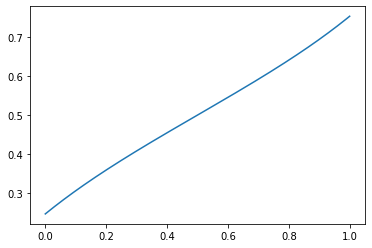

In [6]:

num_funcs = 2*size

BCs = []
#adds the rows that contain the boundary conditions!
for i in range(size):
    BCs.append(i*steps)

for i in range(size, 2*size):
    BCs.append((i+1)*steps-1)
    

A = np.zeros((num_funcs*steps, num_funcs*steps))

x = np.zeros(num_funcs*steps)

#needs to be altered for more general boundary conditions!
x[(size+1)*steps-1] = 2 #non zero boundary condition -> needs to be automated

#giving these the same name messes up subs()!
h_val = 1/(steps-1)

kn_val = 1



coeffs = []


for i in deriv_terms:
    #display(diff_eqs[i])
    diff_eqs[i] = diff_eqs[i].subs([(Kn, kn_val), (h, h_val)])


#won't need coeffs for deriv terms as that should always be 1 due to the solving method!
for i in deriv_terms:
    #display(diff_eqs[i])
    #diff_eqs[i] = diff_eqs[i].subs([(Kn, kn_val), (h, h_val)])
    coeffs.append(Poly(diff_eqs[i], terms).coeffs())
    #display(coeffs[-1])


#maybe split this into two loops? one for the vs and one for the bs?
#display(coeffs[1][1].evalf())

#could just apply boundary conditions at the end???? may be way easier! just replace entire row with zeros then sub in 1 at bc val


#get this to work then see if it is quicker to create each 'block' of the matrix first then smash them together
#each block should be mainly diagonal so could be much quicker!
#dont think the matrix creation is much of a bottleneck though!

for i in range(int(num_funcs/2)):#num funcs should always be an integer? would it be better if num funcs was how many funcs in each region?
    #display(A) 
    
    for j in range(num_funcs):
    
        for k in range(i*steps, (i+1)*steps):
            #print(i, j, k)
            #print(A)
            #print(coeffs[i][j])
            A[k][k+j*steps- i*steps] = coeffs[i][j]

            
#adds the deriv terms
for i in range(int(num_funcs/2)):
    for k in range(i*steps, (i+1)*steps):
        A[k][k-1] = -1

        
#display(A) 
          
for i in range(int(num_funcs/2), num_funcs):
    for j in range(num_funcs):
    
        for k in range(i*steps, (i+1)*steps):
            #print(i, j, k)
            #print(A)
            
            A[k][k+j*steps- i*steps] = coeffs[i][j]
            
for i in range(int(num_funcs/2), num_funcs):
    for k in range(i*steps, (i+1)*steps):
        
        #filthy but this works!
        if not k == steps*num_funcs-1:
            #print(k)
            A[k][k+1] = -1
        
#display(A)

for i in BCs:
    A[i] = np.zeros(num_funcs*steps)
    A[i][i] = 1
    
#print(A)


vb = np.linalg.solve(A, x)

res = []

for i in range(2*size):
    res.append(vb[i*steps:(i+1)*steps])


#print(b1[-1])
#print(v1[0])
#print(x)

#print(vb)



#this needs to be automated big time!
#u_2_fin = 1/(4*np.pi**(3/2))*(np.pi**(3/2)*b1 - np.pi*b2 + np.pi**(3/2)*v1 + np.pi*v2)


#this works!
u_lam = lambdify(terms, u_x)



#print(u_2_fin)

#print(u_2_fin)

y_vals = np.linspace(0,1, steps)
#print(y_vals)
plt.plot(y_vals, u_lam(*res))
#plt.plot(y_vals, u_2_fin)
plt.show()